# Degradation Modelling 

This rover shows how degradation modelling can be performed to model the resilience of an engineered system over its entire lifecycle.

In [1]:
import fmdtools.analyze as an
import fmdtools.sim.propagate as prop
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp

In [2]:
from examples.rover.rover_degradation import DriveDegradation, PSFDegradationLong, PSFDegradationShort

Degradation models are defined independently of the fault model, but have attributes (e.g., functions) which may correspond to it directly.

Because degradation may only occur in specific functions/flows (and may not have inter-functional dependencies), it is not necessary for the degradation model to have the same 

In [3]:
deg_mdl = DriveDegradation()
deg_mdl

drivedegradation DriveDegradation
- DriveDegradationStates(wear=0.0, corrosion=0.0, friction=0.0, drift=0.0)

In [4]:
deg_mdl_hum_long = PSFDegradationLong()
deg_mdl_hum_long

psfdegradationlong PSFDegradationLong
- PSFDegradationLongStates(experience=0.0)

In [5]:
deg_mdl_hum_short = PSFDegradationShort()
deg_mdl_hum_short

psfdegradationshort PSFDegradationShort
- PSFDegradationShortStates(fatigue=0, stress=0.0)

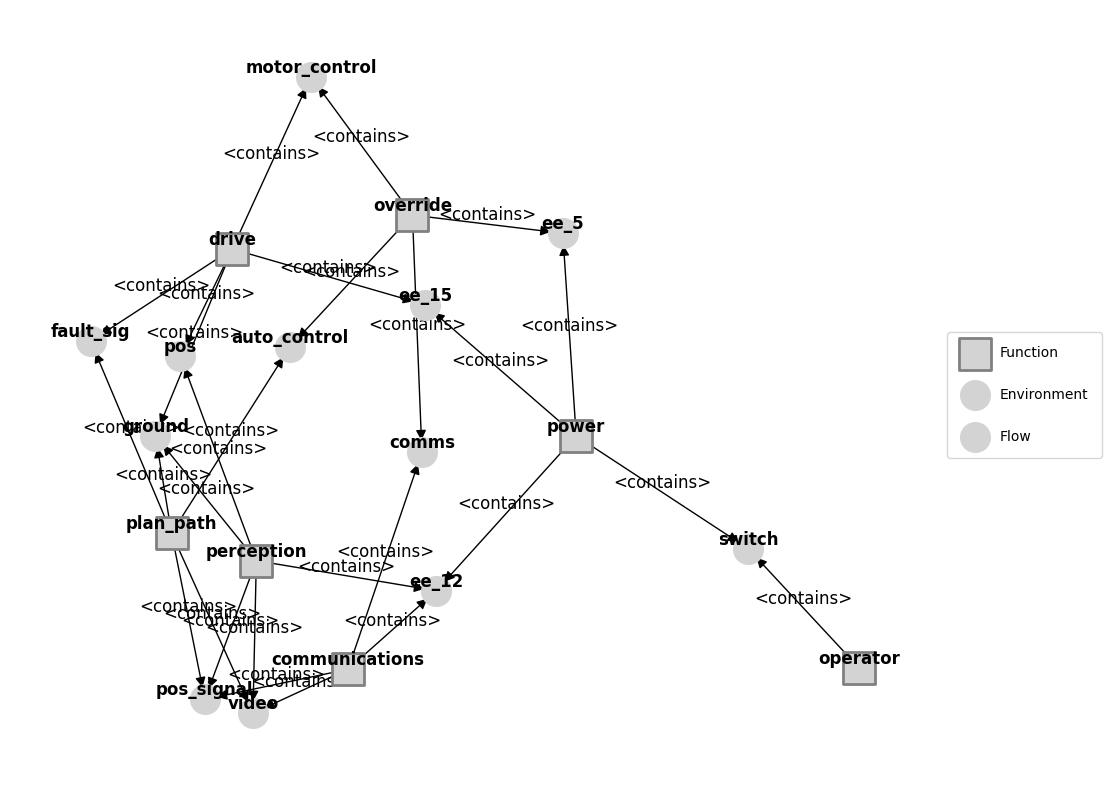

In [6]:
from examples.rover.rover_model import Rover, plot_map
fault_mdl = Rover(p={'ground':{'linetype': 'turn'}})
graph = an.graph.FunctionArchitectureGraph(fault_mdl)
fig, ax = graph.draw()

In [7]:
fig.savefig("func_model.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

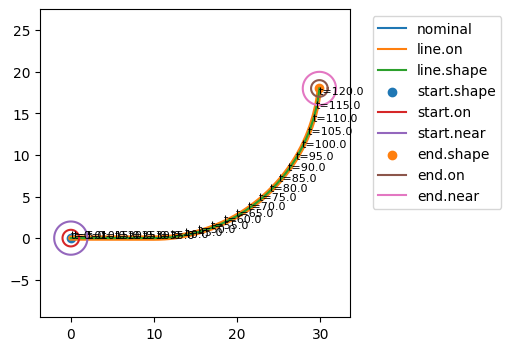

In [8]:
endresults, mdlhist = prop.nominal(fault_mdl)
fig, ax = plot_map(fault_mdl, mdlhist)

In [9]:
fig.savefig("sine_rover_environment.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

As shown, there are two degradation models here:
- one which focusses solely on faults in the drive system, and
- one which focusses on the human degradation of fatigue
Below we simulate these to model to the degradation behaviors being modelled in this drive system.

## Drive Degradation

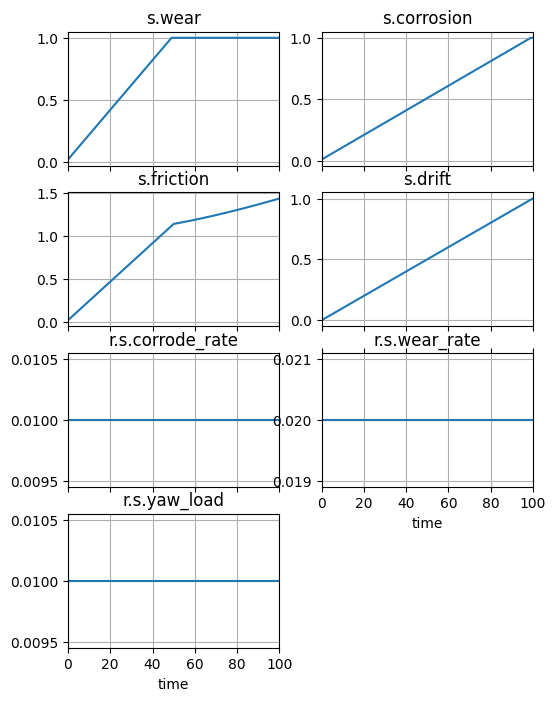

In [10]:
deg_mdl = DriveDegradation()
endresults, mdlhist = prop.nominal(deg_mdl)
fig, ax = mdlhist.plot_line('s.wear', 's.corrosion', 's.friction', 's.drift', 'r.s.corrode_rate', 'r.s.wear_rate', 'r.s.yaw_load')

The major behaviors are:
- wear
- corrosion
- friction
- drift

These behaviors result from the accumulation of the following rates over each time-step:
- yaw_load 
- corrode_rate
- wear_rate

These degradation behaviors have additionally been defined to simulate stochastically if desired:

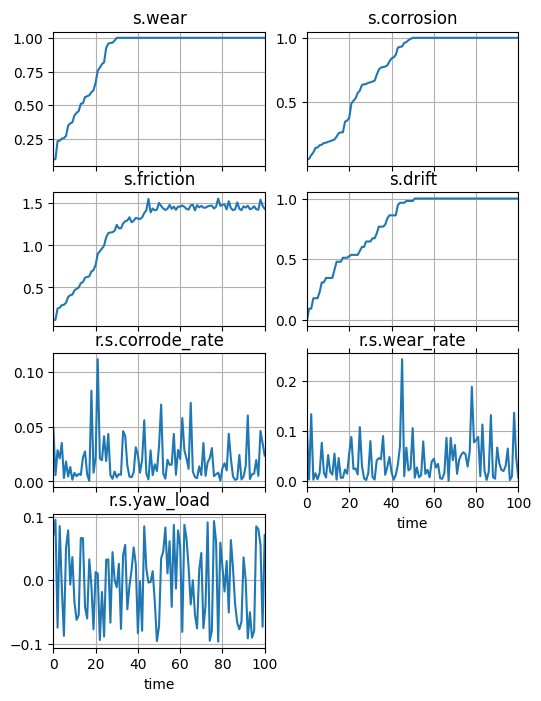

In [11]:
deg_mdl = DriveDegradation()
endresults, mdlhist = prop.nominal(deg_mdl, run_stochastic=True)
fig, ax = mdlhist.plot_line('s.wear', 's.corrosion', 's.friction', 's.drift', 'r.s.corrode_rate', 'r.s.wear_rate', 'r.s.yaw_load')

To get averages/percentages over a number of scenarios, we can view these behaviors over a given number of random seeds:

In [12]:
from fmdtools.sim.sample import ParameterSample
ps = ParameterSample()
ps.add_variable_replicates([], replicates=100, seed_comb='independent')
endclasses_deg, mdlhists_deg = prop.parameter_sample(deg_mdl, ps, run_stochastic=True)

SCENARIOS COMPLETE:   0%|          | 0/100 [00:00<?, ?it/s]

SCENARIOS COMPLETE: 100%|██████████| 100/100 [00:00<00:00, 143.80it/s]


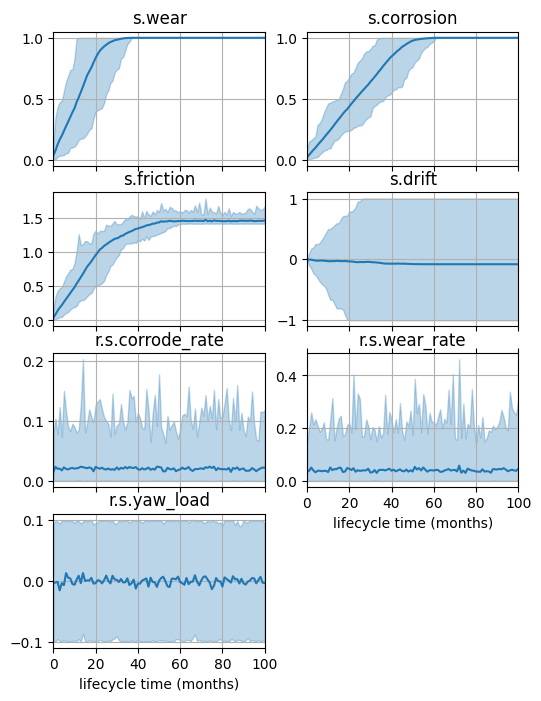

In [13]:
fig, ax = mdlhists_deg.plot_line('s.wear', 's.corrosion', 's.friction', 's.drift',
                                 'r.s.corrode_rate', 'r.s.wear_rate', 'r.s.yaw_load',
                                 title="", xlabel='lifecycle time (months)', aggregation = 'mean_bound')

In [14]:
fig.savefig("drive_degradations.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

As shown, while wear and friction proceed monotonically, drift can go one way or another, meaning that whether the rover drifts left or right is basically up to chance. We can further look at slices of these distributions:

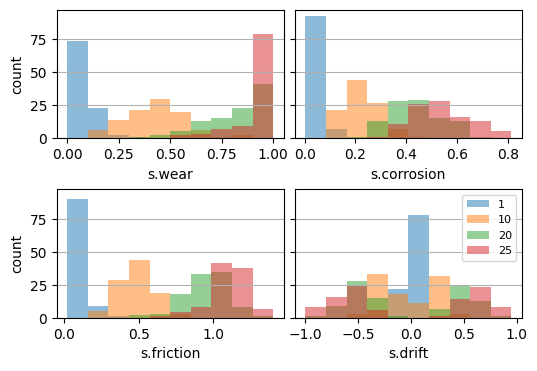

In [15]:
fig, axs = mdlhists_deg.plot_metric_dist([1, 10, 20, 25], 's.wear', 's.corrosion', 's.friction', 's.drift', bins=10, alpha=0.5)

Given the parameter information (friction and drift) that the degradation model produced, we can now simulate the model with this information over time in the nominal scenarios.

In [16]:

from fmdtools.sim.sample import ParameterDomain, ParameterSample

In [17]:
# from examples.rover.rover_model_human import RoverHumanParam
# pd = ParameterDomain(RoverHumanParam)
# pd.add_variables('degradation.friction', 'degradation.drift')
# pd.add_variables('psfs.stress', 'psfs.fatigue')
mdlhists_deg.get('rep0_var_0').get('s.drift')[1]

0.09457228274937235

In [18]:
from examples.rover.rover_model import RoverParam
RoverParam()

RoverParam(ground=GroundParam(linetype='sine', amp=1.0, period=6.283185307179586, radius=20.0, x_start=10.0, y_end=10.0, x_min=0.0, x_max=30.0, x_res=0.1, path_buffer_on=0.2, path_buffer_poor=0.3, path_buffer_near=0.4, dest_buffer_on=1.0, dest_buffer_near=2.0), correction=ResCorrection(ub_f=10.0, lb_f=-1.0, ub_t=10.0, lb_t=0.0, ub_d=2.0, lb_d=-2.0, cor_d=0.0, cor_t=0.0, cor_f=0.0), degradation=DegParam(friction=0.0, drift=0.0), drive_modes={'mode_args': 'set'})

In [19]:

from fmdtools.analyze.history import History
class ExtendedRoverParam(RoverParam):

    @classmethod
    def from_hist(cls, hist=History, t=1, scen=1, **kwargs):
        ind_hist = hist.get('rep'+str(scen)+'_var_'+str(scen))
        friction = ind_hist.get('s.friction')[t]
        drift = ind_hist.get('s.drift')[t]
        return ExtendedRoverParam(degradation={'friction': friction, 'drift': drift})
        
ep = ExtendedRoverParam.from_hist(hist=mdlhists_deg, t=1, scen=1)
ep.degradation

DegParam(friction=0.058454502858458546, drift=-2.059665499091674e-05)

In [20]:
mdlhists_deg.keys()

dict_keys(['rep0_var_0.s.wear', 'rep0_var_0.s.corrosion', 'rep0_var_0.s.friction', 'rep0_var_0.s.drift', 'rep0_var_0.r.s.corrode_rate', 'rep0_var_0.r.s.wear_rate', 'rep0_var_0.r.s.yaw_load', 'rep0_var_0.r.probdens', 'rep0_var_0.time', 'rep1_var_1.s.wear', 'rep1_var_1.s.corrosion', 'rep1_var_1.s.friction', 'rep1_var_1.s.drift', 'rep1_var_1.r.s.corrode_rate', 'rep1_var_1.r.s.wear_rate', 'rep1_var_1.r.s.yaw_load', 'rep1_var_1.r.probdens', 'rep1_var_1.time', 'rep2_var_2.s.wear', 'rep2_var_2.s.corrosion', 'rep2_var_2.s.friction', 'rep2_var_2.s.drift', 'rep2_var_2.r.s.corrode_rate', 'rep2_var_2.r.s.wear_rate', 'rep2_var_2.r.s.yaw_load', 'rep2_var_2.r.probdens', 'rep2_var_2.time', 'rep3_var_3.s.wear', 'rep3_var_3.s.corrosion', 'rep3_var_3.s.friction', 'rep3_var_3.s.drift', 'rep3_var_3.r.s.corrode_rate', 'rep3_var_3.r.s.wear_rate', 'rep3_var_3.r.s.yaw_load', 'rep3_var_3.r.probdens', 'rep3_var_3.time', 'rep4_var_4.s.wear', 'rep4_var_4.s.corrosion', 'rep4_var_4.s.friction', 'rep4_var_4.s.drift',

In [21]:
ps.get_scen_groups()

{(): ['rep0_var_0',
  'rep1_var_1',
  'rep2_var_2',
  'rep3_var_3',
  'rep4_var_4',
  'rep5_var_5',
  'rep6_var_6',
  'rep7_var_7',
  'rep8_var_8',
  'rep9_var_9',
  'rep10_var_10',
  'rep11_var_11',
  'rep12_var_12',
  'rep13_var_13',
  'rep14_var_14',
  'rep15_var_15',
  'rep16_var_16',
  'rep17_var_17',
  'rep18_var_18',
  'rep19_var_19',
  'rep20_var_20',
  'rep21_var_21',
  'rep22_var_22',
  'rep23_var_23',
  'rep24_var_24',
  'rep25_var_25',
  'rep26_var_26',
  'rep27_var_27',
  'rep28_var_28',
  'rep29_var_29',
  'rep30_var_30',
  'rep31_var_31',
  'rep32_var_32',
  'rep33_var_33',
  'rep34_var_34',
  'rep35_var_35',
  'rep36_var_36',
  'rep37_var_37',
  'rep38_var_38',
  'rep39_var_39',
  'rep40_var_40',
  'rep41_var_41',
  'rep42_var_42',
  'rep43_var_43',
  'rep44_var_44',
  'rep45_var_45',
  'rep46_var_46',
  'rep47_var_47',
  'rep48_var_48',
  'rep49_var_49',
  'rep50_var_50',
  'rep51_var_51',
  'rep52_var_52',
  'rep53_var_53',
  'rep54_var_54',
  'rep55_var_55',
  'rep56

In [23]:
mdlhists_deg.get_comp_groups('fiction', 'drift')

default: 
--rep0_var_0.s.drift:         array(101)
--rep0_var_0.time:            array(101)
--rep1_var_1.s.drift:         array(101)
--rep1_var_1.time:            array(101)
--rep2_var_2.s.drift:         array(101)
--rep2_var_2.time:            array(101)
--rep3_var_3.s.drift:         array(101)
--rep3_var_3.time:            array(101)
--rep4_var_4.s.drift:         array(101)
--rep4_var_4.time:            array(101)
--rep5_var_5.s.drift:         array(101)
--rep5_var_5.time:            array(101)
--rep6_var_6.s.drift:         array(101)
--rep6_var_6.time:            array(101)
--rep7_var_7.s.drift:         array(101)
--rep7_var_7.time:            array(101)
--rep8_var_8.s.drift:         array(101)
--rep8_var_8.time:            array(101)
--rep9_var_9.s.drift:         array(101)
--rep9_var_9.time:            array(101)
--rep10_var_10.s.drift:       array(101)
--rep10_var_10.time:          array(101)
--rep11_var_11.s.drift:       array(101)
--rep11_var_11.time:          array(101)
--rep1

In [80]:
class ParameterResultSample(ParameterSample):
    def __init__(self, res, *vars, comp_groups={}, **kwargs):
        ParameterSample.__init__(self, **kwargs)
        self.res_to_sample = res.get_comp_groups(*vars, **comp_groups)
        self.vars = vars

    def _get_repname(self, comp_group, rep):
        if type(rep) == int:
            return [*self.res_to_sample[comp_group].nest().keys()][rep]
        elif type(rep) == str:
            return rep
        else:
            raise Exception("Invalid option for rep: "+str(rep))

    def _get_param(self, comp_group, rep, var, t=None):
        if t is None:
            return self.res_to_sample[comp_group].get(rep).get(var)
        elif type(t)==int:
            return self.res_to_sample[comp_group].get(rep).get(var)[t]
        else:
            return Exception("Invalid option for t: "+str(t))
    
    def _get_reps(self, comp_group, reps):
        reps_possible = [*self.res_to_sample[comp_group].nest().keys()]
        if reps == 'all':
            reps_to_sample = reps_possible
        elif type(reps) == int:
            reps_to_sample = reps_possible[:reps]
        elif type(reps) == list:
            reps_to_sample = reps
        else:
            raise Exception("Invalid option for reps: "+str(reps))
        return reps_to_sample

    def get_param_ins(self, comp_group='default', rep=1, t=None):
        param_list = []
        rep = self._get_repname(comp_group, rep)
        for var in self.vars:  
            param_list.append(self._get_param(comp_group, rep, var, t))
        return param_list

    def add_res_scenario(self, comp_group='default', rep=1, t=None, name='res', **kwargs):
        param_list = self.get_param_ins(comp_group, rep, t)
        self.add_variable_scenario(*param_list, name=name, **kwargs)

    def add_res_reps(self, comp_group='default', reps='all', name='res, **kwargs'):
        reps_to_sample = self._get_reps(comp_group, reps)
        for rep in reps_to_sample:
            self.add_res_scenario(comp_group, rep, name=name, **kwargs)


In [89]:
class ParameterHistSample(ParameterResultSample):

    def add_hist_scenario(self, comp_group='default', rep=1, t=1, name='hist', **kwargs):
        self.add_res_scenario(comp_group, rep, t, name, **kwargs)

    def _get_times(self, comp_group, rep, ts):
        res = self.res_to_sample[comp_group].get(rep)
        if ts == 'all':
            ts_to_sample = [i for i, e in enumerate(res.time)]
        elif type(ts) == int:
            ts_to_sample = [*np.arange(0, len(res.time), ts)]
        elif type(ts) == list:
            ts_to_sample = ts
        elif type(ts) == tuple:
            ts_to_sample = [*np.arange(*ts)]
        else:
            raise Exception("Invalid option for ts: "+str(ts))
        return ts_to_sample

    def add_hist_times(self, comp_group, rep, ts='all', **kwargs):
        rep = self._get_repname(comp_group, rep)
        ts_to_sample = self._get_times(comp_group, rep, ts)
        for t in ts_to_sample:
            self.add_hist_scenario(comp_group, rep, t, **kwargs)
    
    def add_hist_reps(self, comp_group, reps='all', ts='all', **kwargs):
        reps_to_sample = self._get_reps(comp_group, reps)
        for rep in reps_to_sample:
            self.add_hist_times(comp_group, rep, ts)

    def add_hist_groups(self, comp_groups=['default'], reps='all', ts='all', **kwargs):
        for comp_group in comp_groups:
            self.add_hist_reps(comp_group, reps=reps, ts=ts, **kwargs)

In [38]:
rpd = ParameterDomain(RoverParam)
rpd.add_variables('degradation.friction', 'degradation.drift')
rpd(1, 10).degradation

DegParam(friction=1.0, drift=10.0)

In [90]:
phs = ParameterHistSample(mdlhists_deg, 's.friction', 's.drift', paramdomain=rpd)
phs._get_repname('default', 1)

'rep96_var_96'

In [91]:

phs.get_param_ins(rep=0, t=1)

[0.14807504001580432, 6.676170780609324e-05]

In [92]:
phs.add_hist_groups(reps= 10, ts = [1, 10, 20, 25])

In [ ]:
# phs.add_hist_scenario(comp_group='default', rep=3, t=1, name='hist')

In [93]:
len(phs.scenarios())

40

defining parameter domain

from rover_model_human import 

In [ ]:
behave_nomapp = NominalApproach()
behave_nomapp.add_param_ranges(gen_sample_params_comp, 'behave_nomapp', mdlhists_deg, t=(1,12,1), scen = (1,30,1), turn='sine')

NameError: name 'NominalApproach' is not defined

In [ ]:
mdl=Rover(valparams={'end_rad':3.0})
behave_endclasses, behave_mdlhists = prop.nominal_approach(mdl, behave_nomapp)

In [ ]:
fig = an.plot.nominal_vals_2d(behave_nomapp, behave_endclasses, 't', 'scen', xlabel='lifecycle time (months)', ylabel='scenario', legendloc='upper left', metric='at_finish', nomlabel='True')

In [ ]:
fig.savefig("drive_deg_envelope.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [ ]:
fig = plot_trajectories(behave_mdlhists)

As shown, as the time (and thus degradation) increases, the rover becomes more likely to be unable to complete the mission. In this case, it results in the rover not completing the mission in time.

In [ ]:
behave_endclasses_nested, behave_mdlhists_nested, behave_apps_nested = prop.nested_approach(mdl, behave_nomapp, pool=mp.Pool(5), faults='Drive', track='flows')


Finally, we can also visualize simulate and then view the effect of the degradation on average resilience...

In [ ]:
res_comp = an.tabulate.nested_factor_comparison(behave_nomapp, behave_endclasses_nested, ['t'], 'at_finish', percent=False)
fig = an.plot.nested_factor_comparison(res_comp, stack=True, maxy=1.1, xlabel='lifecycle time (months)', figsize=(5.5,4), title="", stat="proportion complete")   

In [ ]:
fig.savefig("drive_resilience_degradation.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

As shown, while there is some resilience early in the lifecycle (resulting in a small proportion of faults being recovered), this resilience goes away with degradation.

In [ ]:
res_comp

## Human Degradation

We can also perform this assessment for the human error model, which is split up into two parts:
- long term "degradation" of experience over months
- short term "degradation" of stress and fatigue over a day

In [ ]:
deg_mdl_hum_long = HumanDegradationLong()
endresults,  mdlhist_hum_long = prop.nominal(deg_mdl_hum_long)
fig,ax = an.plot.mdlhists(mdlhist_hum_long)

In [ ]:
nomapp_hum_long = NominalApproach()
experience_param = np.random.default_rng(seed=101).gamma(1,1.9,101)
experience_param = list(experience_param)
nomapp_hum_long.add_param_ranges(gen_long_degPSF_param, 'nomapp_hum_long', experience_param, scen = (0,25,1))

In [ ]:
endclasses, mdlhists_hum_long = prop.nominal_approach(deg_mdl_hum_long, nomapp_hum_long, run_stochastic=True)

In [ ]:
fig,ax = an.plot.mdlhists(mdlhists_hum_long, aggregation='mean_std', time_slice = [1,5,9,13], legend_loc=-1, xlabel="time (months)", ylabels={("functions", "Control", "experience"):"experience"})

In [ ]:
fig.savefig("experience_degradation.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

Short-term degradation

In [ ]:
deg_mdl_hum_short = HumanDegradationShort()
endresults, mdlhist_hum_short = prop.nominal(deg_mdl_hum_short)
fig, axs = an.plot.mdlhists(mdlhist_hum_short)
endresults, mdlhist_hum_short = prop.nominal(deg_mdl_hum_short, run_stochastic=True)
fig, axs = an.plot.mdlhists(mdlhist_hum_short)

In [ ]:
mdlhist_hum_short

short-term degradation (over no external params)

In [ ]:
nomapp_human_short = NominalApproach()
nomapp_human_short.add_seed_replicates('test', 25)

In [ ]:
endclasses_human_short, mdlhists_human_short = prop.nominal_approach(deg_mdl_hum_short, nomapp_human_short, run_stochastic=True)

In [ ]:
fig, ax = an.plot.mdlhists(mdlhists_human_short, aggregation='mean_std')

short-term degradation over long-term params

In [ ]:
stress_param = np.random.default_rng(seed=101).gamma(2,1.9,101)
stress_param = list(stress_param)

In [ ]:
nomapp_short_long = NominalApproach()
nomapp_short_long.add_param_ranges(gen_short_degPSF_param, 'nomapp', mdlhists_hum_long, stress_param, scen = (0,25,1), t= (1,15,4))
nomapp_short_long.update_factor_seeds('nomapp', 'scen')

In [ ]:
endclasses, mdlhists_hum_short_long = prop.nominal_approach(deg_mdl_hum_short, nomapp_short_long, run_stochastic=True)    

In [ ]:
nomapp_short_long.ranges['nomapp']['inputranges']

In [ ]:
comp_groups = nomapp_short_long.get_param_scens('nomapp', 't')

In [ ]:
fig, ax = an.plot.mdlhists(mdlhists_hum_short_long, fxnflowvals={"Control":"stress"}, comp_groups=comp_groups, aggregation='mean_std',
                           xlabel="time (hours)", cols=1,ylabels={("functions", "Control", "stress"):"stress"}, legend_title='month')

In [ ]:
fig.savefig("stress_degradation.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [ ]:
behave_nomapp_hum = NominalApproach()
behave_nomapp_hum.add_param_ranges(gen_human_params_combined, 'behave_nomapp_hum', mdlhists_hum_short_long, nomapp_short_long, 'nomapp', t_stress=(1,11, 2), t_exp=(1,15,4), scen = (1,25, 1), turn='sine')

In [ ]:
mdl=Rover(valparams={'end_rad':3.0})
behave_endclasses_hum, behave_mdlhists_hum = prop.nominal_approach(mdl, behave_nomapp_hum, run_stochastic=True)   

In [ ]:
fig = an.plot.nominal_vals_2d(behave_nomapp_hum, behave_endclasses_hum, 't_stress', 'scen', xlabel='single-day time (hours)', ylabel='scenario',  metric='at_finish', nomlabel='True')

In [ ]:
fig = an.plot.nominal_vals_2d(behave_nomapp_hum, behave_endclasses_hum, 't_exp', 'scen', xlabel='learning time (months)', ylabel='scenario',  metric='at_finish', nomlabel='True')

In [ ]:
fig = an.plot.nominal_vals_3d(behave_nomapp_hum, behave_endclasses_hum, 't_stress', 't_exp', 'scen', xlabel='single-day time (hours)', ylabel = 'experience time (months)', zlabel='scenario',  metric='at_finish', nomlabel='True', title="Mission Successes")

In [ ]:
fig.savefig("human_nominal_joint_degradation.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [ ]:
fig = plot_trajectories(behave_mdlhists_hum)

In [ ]:
fig, ax = an.plot.mdlhists(behave_mdlhists_hum, fxnflowvals='GlobalPSF',   legend_loc=False)

In [ ]:
fig, ax = an.plot.metric_dist_from(behave_mdlhists_hum, 1, fxnflowvals={'GlobalPSF':'stress'})

In [ ]:
nom_comp_hum = an.tabulate.nominal_factor_comparison(behave_nomapp_hum, behave_endclasses_hum, ['t_exp','t_stress'], ['at_finish'], give_ci=True, return_anyway=True, percent=True)
nom_comp_hum

In [ ]:
scendict = behave_nomapp_hum.get_param_scens('behave_nomapp_hum', 't_exp','t_stress')
late_scens = scendict[13,5]
early_scens= scendict[13,1]

In [ ]:
late_scens

In [ ]:
early_scens

In [ ]:
behave_nomapp_hum.scenarios['behave_nomapp_hum_90'].p

In [ ]:
plt.hist([behave_nomapp_hum.scenarios[scen].p['stress'] for scen in early_scens], alpha=0.5, label='early')
plt.hist([behave_nomapp_hum.scenarios[scen].p['stress'] for scen in late_scens], alpha=0.5, label='late')
plt.legend()

In [ ]:
behave_endclasses_hum

In [ ]:
plt.hist([int(behave_endclasses_hum[scen]['at_finish']) for scen in early_scens], alpha=0.5, label='early')
plt.hist([float(behave_endclasses_hum[scen]['at_finish']) for scen in late_scens], alpha=0.5, label='late')
plt.legend()

In [ ]:
plt.hist([behave_endclasses_hum[scen]['end_dist'] for scen in early_scens], alpha=0.5, label='early')
plt.hist([behave_endclasses_hum[scen]['end_dist'] for scen in late_scens], alpha=0.5, label='late')
plt.legend()

In [ ]:
fig = an.plot.nominal_factor_comparison(nom_comp_hum, 'at_finish', maxy=1.1, xlabel='single-day time (hours)', figsize=(10,6), title="", error_bars=True)  

In [ ]:
nom_comp_hum = an.tabulate.nominal_factor_comparison(behave_nomapp_hum, behave_endclasses_hum, ['t_exp'], ['at_finish'], percent=False)
nom_comp_hum

In [ ]:
nom_comp_hum = an.tabulate.nominal_factor_comparison(behave_nomapp_hum, behave_endclasses_hum, ['t_stress'], ['at_finish'],  percent=False)
nom_comp_hum

As for the human resilience:

In [ ]:
behave_endclasses_nested_hum, behave_mdlhists_nested_hum, behave_apps_nested_hum = prop.nested_approach(mdl, behave_nomapp_hum, pool=mp.Pool(5), faults='Drive', track='flows')

In [ ]:
res_comp_hum = an.tabulate.nested_factor_comparison(behave_nomapp_hum, behave_endclasses_nested_hum, ['t_exp','t_stress'], 'at_finish')
res_comp_hum

In [ ]:
fig = an.plot.nested_factor_comparison(res_comp_hum, stack=True, maxy=1.1, xlabel='t_experience (months), t_stress (hours)', figsize=(10,4), title="", stat="proportion complete")  

In [ ]:
fig.savefig("human_resilience_degradation.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [ ]:
res_comp_hum

## Combined Degradation

Idea: make same resilience plots as before but with degradation of resilience to drive faults at 0, 4, and 8 hours of fatigue.

Need method of doing this:
- take params for one and replace with the other (kind of hacky and requires independence)
- create composite of both? (how do you determine the merge between output params?)
- use a combined method with both histories as input and sample over t_life and t_day (use this one)

In [ ]:
joint_nomapp = NominalApproach()
joint_nomapp.add_param_ranges(gen_sample_params_combined, 'behave_jointapp', mdlhists_deg, mdlhists_hum_short_long, nomapp_short_long, stress_id='nomapp',  t_comp=(1,26,12), t_stress=(1,11, 4), t_exp=(1,10,8), scen = (1,25,1), turn='sine')

In [ ]:
mdl=Rover(valparams={'end_rad':3.0})
behave_endclasses_joint, behave_mdlhists_joint = prop.nominal_approach(mdl, joint_nomapp)

In [ ]:
fig = an.plot.nominal_vals_3d(joint_nomapp, behave_endclasses_joint, 't_comp', 't_stress', 'scen', xlabel='lifecycle time (months)', ylabel='single-day time (hours)', zlabel='scenario',  metric='at_finish', nomlabel='True')

In [ ]:
nom_comp_hum = an.tabulate.nominal_factor_comparison(joint_nomapp, behave_endclasses_joint, ['t_exp', 't_comp', 't_stress'], ['at_finish'], percent=False, return_anyway=True)
nom_comp_hum

In [ ]:
nom_comp_hum.columns

In [ ]:
fig = an.plot.nominal_factor_comparison(nom_comp_hum, 'at_finish', maxy=1.1, xlabel='single-day time (hours)', figsize=(16,4), title="", error_bars=True)  

Resilience assessment

In [ ]:
behave_endclasses_nested_joint, behave_mdlhists_nested_hum, _ = prop.nested_approach(mdl, joint_nomapp, pool=mp.Pool(5), faults='Drive', track='flows')

In [ ]:
res_joint = an.tabulate.nested_factor_comparison(joint_nomapp, behave_endclasses_nested_joint, ['t_exp', 't_comp', 't_stress'], 'at_finish', percent=False) 

In [ ]:
res_joint

In [ ]:
fig = an.plot.nested_factor_comparison(res_joint, stack=True, maxy=1.1, xlabel='t_experience, t_component, t_stress', figsize=(12,4), title="", stat="proportion complete") 

In [ ]:
fig.savefig("joint_resilience_degradation.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)